In [1]:
%matplotlib inline
import torch
from torch import nn
import numpy as np
from torch.utils import data
import ipynb_importer
from io import StringIO
import random
from d2l import torch as d2l
from matplotlib import pyplot as plt
import torchvision
import re
import os
import glob
import functions as funcs

importing Jupyter notebook from functions.ipynb


In [2]:
device_t = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(device_t)

In [3]:
# import data

fstructure_dir0 = '/home/zhengyang/Data/set_6/structures/'
fmoduli_dir0 = '/home/zhengyang/Data/set_6/moduli/'
fstructure_non_dir0 = '/home/zhengyang/Data/set_6_nonsymm/structures/'
fmoduli_non_dir0 = '/home/zhengyang/Data/set_6_nonsymm/moduli/'

fname_structure = funcs.get_symm_structdir(fstructure_dir0)
fname_moduli = funcs.get_symm_modulidir(fmoduli_dir0)
fname_non_structure = funcs.get_nonsymm_structdir(fstructure_non_dir0)
fname_non_moduli = funcs.get_nonsymm_modulidir(fmoduli_non_dir0)

moduli, elems_fnl = funcs.read_symm_data(fname_structure, fname_moduli)
moduli_non, elems_fnl_non = funcs.read_nonsymm_data(fname_non_structure, fname_non_moduli)

In [4]:
# Data type change

elems_fnl = torch.from_numpy(elems_fnl)
elems_fnl = elems_fnl.float()
# print(elems_fnl.shape,'\n',elems_fnl[0][0])
moduli_fnl = torch.from_numpy(moduli)
moduli_fnl = moduli_fnl.float()

In [5]:
## Dataset loading

batch_size = 256

def load_array(data_arrays, batch_size, is_train=True):  #@save    
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)
data_iter = load_array((elems_fnl,), batch_size)
# data_iter = load_array((elems_fnl,moduli_fnl ), batch_size)
# test1 = next(iter(data_iter))
# test1


In [6]:
# Generator

class G_block(nn.Module):
    # data format = 'N C D H W'
    def __init__(self, out_channels, in_channels=100, kernel_size=4, strides=2,
                 padding=1, **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv3d_trans = nn.ConvTranspose3d(in_channels, out_channels,
        
                                               kernel_size, strides, padding,
                                               bias=False)
        self.batch_norm = nn.BatchNorm3d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv3d_trans(X)))

In [7]:
x = torch.zeros((2, 100, 6, 6, 6))
# stride...
g_blk = G_block(out_channels = 1, strides=1, padding=1)
g_blk(x).shape

torch.Size([2, 1, 7, 7, 7])

In [8]:
x = torch.zeros((1, 100, 1, 1, 1))
n_G = 6
g_blk = G_block(in_channels=100, out_channels=n_G * 8,
            strides=1, padding=1)
g_blk(x).shape

torch.Size([1, 48, 2, 2, 2])

In [9]:
n_G = 6
net_G = nn.Sequential(
    G_block(in_channels=100, out_channels=n_G * 8,
            strides=1, padding=1),
    # Output: (48, 2, 2, 2)
    G_block(in_channels=n_G * 8, out_channels=n_G * 4, kernel_size=4, 
            strides=1, padding=1),
    # Output: (24, 3, 3, 3)
    G_block(in_channels=n_G * 4, out_channels=n_G * 2, kernel_size=4, 
            strides=1, padding=1),
    # Output: (12, 4, 4, 4)
    G_block(in_channels=n_G * 2, out_channels=n_G, kernel_size=4, 
            strides=1, padding=1),
    # Output: (6, 5, 5, 5)
    nn.ConvTranspose3d(in_channels=n_G, out_channels=1, kernel_size=4,
                       stride=1, padding=1, bias=False),
    # Output: (N = batch_size, 1, 6, 6, 6)
    nn.Tanh())


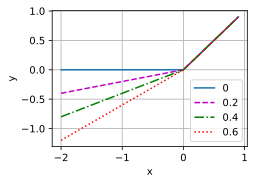

In [10]:
# Discriminator

alphas = [0, .2, .4, .6, .8, 1]
x = torch.arange(-2, 1, 0.1)
Y = [nn.LeakyReLU(alpha)(x).detach().numpy() for alpha in alphas]
d2l.plot(x.detach().numpy(), Y, 'x', 'y', alphas)

In [11]:
class D_block(nn.Module):
    def __init__(self, out_channels, in_channels=1, kernel_size=4, strides=1,
                 padding=1, alpha=0.2, **kwargs):
        super(D_block, self).__init__(**kwargs)
        self.conv3d = nn.Conv3d(in_channels, out_channels, kernel_size,
                                strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm3d(out_channels)
        self.activation = nn.LeakyReLU(alpha, inplace=True)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv3d(X)))

In [12]:
x = torch.zeros((1, 1, 6, 6, 6))
n_D = 6
d_blk = D_block(n_D)
d_blk(x).shape

torch.Size([1, 6, 5, 5, 5])

In [13]:
n_D = 6
net_D = nn.Sequential(
    D_block(n_D),  
    # Output: (6, 5, 5, 5)
    D_block(in_channels=n_D, out_channels=n_D * 2),
    # Output: (12, 4, 4, 4)
    D_block(in_channels=n_D * 2, out_channels=n_D * 4),
    # Output: (24, 3, 3, 3)
    D_block(in_channels=n_D * 4, out_channels=n_D * 8), 
    # Output: (48, 2, 2, 2)
    nn.Conv3d(in_channels=n_D * 8, out_channels=1, kernel_size=2,
              bias=False))  
    # Output: (N =batch_size, 1, 1, 1, 1)

In [19]:
# Surrogate Model for FE calculation

# class surr_fe(nn.Module):
    

In [20]:
# Real FE calculation by Spyfe



In [15]:
def update_D(X, Z, net_D, net_G, loss, trainer_D):
    """Update discriminator.
    Defined in :numref:`sec_basic_gan`"""
    batch_size = X.shape[0]
    ones = torch.ones((batch_size,), device=X.device)
    zeros = torch.zeros((batch_size,), device=X.device)
    trainer_D.zero_grad()
    real_Y = net_D(X)
    fake_X = net_G(Z)
    # Do not need to compute gradient for `net_G`, detach it from
    # computing gradients.
    fake_Y = net_D(fake_X.detach())
    loss_D = (loss(real_Y, ones.reshape(real_Y.shape)) +
              loss(fake_Y, zeros.reshape(fake_Y.shape))) / 2
    loss_D.backward()
    trainer_D.step()
    return loss_D

In [16]:
def update_G(Z, net_D, net_G, loss, trainer_G):
    """Update generator.
    Defined in :numref:`sec_basic_gan`"""
    batch_size = Z.shape[0]
    ones = torch.ones((batch_size,), device=Z.device)
    trainer_G.zero_grad()
    # We could reuse `fake_X` from `update_D` to save computation
    fake_X = net_G(Z)
    # Recomputing `fake_Y` is needed since `net_D` is changed
    fake_Y = net_D(fake_X)
    loss_G = loss(fake_Y, ones.reshape(fake_Y.shape))
    loss_G.backward()
    trainer_G.step()
    return loss_G

In [17]:
# Training
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device = device_t):
    # BCE loss
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        # Fills the input Tensor with values drawn from the normal distribution 
        # mean = 0, std = 0.02
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    net_D, net_G = net_D.to(device_t), net_G.to(device_t)
    trainer_hp = {'lr': lr, 'betas': [0.5, 0.999]}
    trainer_D = torch.optim.Adam(net_D.parameters(), **trainer_hp)
    trainer_G = torch.optim.Adam(net_G.parameters(), **trainer_hp)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for (X,) in data_iter:
#         for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1, 1))
            X, Z = X.to(device), Z.to(device)
            metric.add(update_D(X, Z, net_D, net_G, loss, trainer_D),
                       update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Show generated examples
        Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1), device=device)
        # Normalize the synthetic data to N(0, 1)
#         fake_x = net_G(Z).permute(0, 2, 3, 1) / 2 + 0.5
#         imgs = torch.cat([
#             torch.cat([fake_x[i * 7 + j].cpu().detach()
#                        for j in range(7)], dim=1)
#             for i in range(len(fake_x) // 7)], dim=0)
#         animator.axes[1].cla()
#         animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

loss_D 0.000, loss_G 15.329, 11225.2 examples/sec on cuda


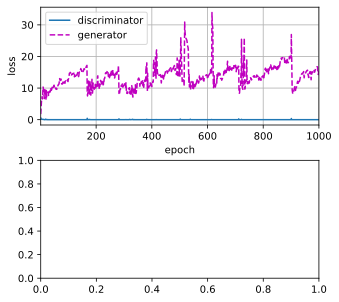

In [18]:
latent_dim, lr, num_epochs = 100, 0.005, 1000
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)